<pre>
<b>
COMP-6721 | 2021-Winter
Project | Part-1

Pravesh Gupta | 40152506
Vikramjeet Singh | 40134477
Manjot Kaur Dherdi | 40107905
</b>
</pre>

# 1. Data Loading

## 1.1. Installing required python modules

In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pandas

  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install scikit-image

  Using cached networkx-2.5.1-py3-none-any.whl (1.6 MB)
  Using cached imageio-2.9.0-py3-none-any.whl (3.3 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.6
    Uninstalling decorator-5.0.6:
      Successfully uninstalled decorator-5.0.6
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=bf0934a3f7dbcc9738c51cc3154cb2c13be8934cf9161489ab7765da733fd710
Note: you may need to restart the kernel to use updated packages.  Stored in directory: c:\users\prave\appdata\local\pip\cache\wheels\e4\7b\98\b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c

Successfully built sklearn


In [10]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


### 1.2. Dataset Description


Required Dataset Folder Heirarchy:
<pre>
{dataset_folder}
--images
----mask
-------{mask images}
----no_mask
-------{no mask images}
----not_person
-------{not person images}
</pre>

### 1.3. Defining Pytorch dataset Representation and data transaformers

In [4]:
from torchvision.datasets import VisionDataset
import pandas as pd
import os
from skimage import io as sk_io, transform as sk_transform
import numpy as np
from sklearn.utils import shuffle
from PIL import Image
    
class Rescale(object):
    def __init__(self, output_size, debug=False, export_path=None):
        assert isinstance(output_size, (int))
        self.output_size = output_size

    def __call__(self, img_data):
        img_arr = np.array(img_data)
        h, w, c = img_arr.shape
        isAlreadyScaled = (h==self.output_size and w==self.output_size)
        
        if not isAlreadyScaled:
            scale_factor = float(self.output_size)/img_arr.shape[0]
            img_arr = (sk_transform.rescale(img_arr, (scale_factor, scale_factor, 1))*255).astype(np.uint8)

            new_w = img_arr.shape[1]

            # Clipping or filling
            if new_w>self.output_size:
                mid = new_w//2
                new_w_start = mid-self.output_size//2
                new_w_end = mid+self.output_size//2

                if (new_w_end-new_w_start)<self.output_size:
                    new_w_end += (self.output_size-(new_w_end-new_w_start))
                elif (new_w_end-new_w_start)>self.output_size:
                    new_w_end -= ((new_w_end-new_w_start)-self.output_size)
                img_arr = img_arr[:, new_w_start:new_w_end]
            elif new_w<self.output_size:
                mid = new_w//2
                new_w_start = self.output_size//2-mid
                new_w_end = new_w_start+new_w
                filled_img_arr = np.zeros((self.output_size, self.output_size, img_arr.shape[2]), dtype=np.uint8)
                filled_img_arr[:, new_w_start:new_w_end] = img_arr[:, :]
                img_arr = filled_img_arr
        return Image.fromarray(img_arr)

### 1.4. (Optional) Prior conversion of image to speed up training process

In [ ]:
from PIL import Image

torch.manual_seed(6721)
np.random.seed(6721)

rescaled_size=512

scaler = Rescale(rescaled_size)

data_dir = './data/images_original/'
copy_dir = './data/images_rescaled/'

if not os.path.isdir(copy_dir):
    os.mkdir(copy_dir)

data_transform = Compose([
    Rescale(rescaled_size)
])

dataset = ImageFolder(
    root=data_dir
    ,transform=data_transform
)
print(f'Dataset: size: {len(dataset)}, class labels: {dataset.class_to_idx}')

label_to_class_dir = {}
for class_name in dataset.class_to_idx:
    label = dataset.class_to_idx[class_name]
    class_dir = copy_dir + class_name + '/'
    label_to_class_dir[label] = class_dir
    if not os.path.isdir(class_dir):
        os.mkdir(class_dir)

for i in range(len(dataset.imgs)):
    url, label = dataset.imgs[i]
    img_name = url.split('\\')[1]
    img_file_path = label_to_class_dir[label] + img_name
    
    if not os.path.isfile(img_file_path):
        item = dataset.__getitem__(i)
        rescaled_img = item[0]
        rescaled_img.save(img_file_path, check_contrast=False)

### 1.5. Creating dataset and data loaders for train and test

From whole dataset, split and find train/test dataset data points

In [2]:
train_images_per_class = 600
test_images_per_class = 100

def get_train_test_indices(dataset_targets):
    test_indices_map = {}
    for class_name in dataset.class_to_idx:
        label = dataset.class_to_idx[class_name]
        test_indices_map[label] = {'indices': np.array([], dtype=np.int32), 'count': 0}

    train_indices_map = {}
    for class_name in dataset.class_to_idx:
        label = dataset.class_to_idx[class_name]
        train_indices_map[label] = {'indices': np.array([], dtype=np.int32), 'count': 0}

    targets = np.array(dataset.targets, dtype=np.int32)
    target_indices = np.where(targets!=None)[0]
    np.random.shuffle(target_indices)

    for i in target_indices:
        label = dataset.targets[i]
        if test_indices_map[label]['count']<test_images_per_class:
            test_indices_map[label]['indices'] = np.append(test_indices_map[label]['indices'], i)
            test_indices_map[label]['count']+=1
        elif train_indices_map[label]['count']<train_images_per_class:
            train_indices_map[label]['indices'] = np.append(train_indices_map[label]['indices'], i)
            train_indices_map[label]['count']+=1

    test_indices = np.array([], dtype=np.int32)
    train_indices = np.array([], dtype=np.int32)

    for class_name in dataset.class_to_idx:
        label = dataset.class_to_idx[class_name]
        label_test_indices = test_indices_map[label]['indices']
        test_indices = np.append(test_indices, label_test_indices)

        label_train_indices = train_indices_map[label]['indices']
        train_indices = np.append(train_indices, label_train_indices)
    return train_indices, test_indices

In [3]:
#For Bias Testing

In [2]:
test_images_per_class = 260
test_images_per_class = 50

def get_train_test_indices(dataset_targets):
    test_indices_map = {}
    for class_name in dataset.class_to_idx:
        label = dataset.class_to_idx[class_name]
        test_indices_map[label] = {'indices': np.array([], dtype=np.int32), 'count': 0}

    train_indices_map = {}
    for class_name in dataset.class_to_idx:
        label = dataset.class_to_idx[class_name]
        train_indices_map[label] = {'indices': np.array([], dtype=np.int32), 'count': 0}

    targets = np.array(dataset.targets, dtype=np.int32)
    target_indices = np.where(targets!=None)[0]
    np.random.shuffle(target_indices)

    for i in target_indices:
        label = dataset.targets[i]
        if test_indices_map[label]['count']<test_images_per_class:
            test_indices_map[label]['indices'] = np.append(test_indices_map[label]['indices'], i)
            test_indices_map[label]['count']+=1
        elif train_indices_map[label]['count']<train_images_per_class:
            train_indices_map[label]['indices'] = np.append(train_indices_map[label]['indices'], i)
            train_indices_map[label]['count']+=1

    test_indices = np.array([], dtype=np.int32)
    train_indices = np.array([], dtype=np.int32)

    for class_name in dataset.class_to_idx:
        label = dataset.class_to_idx[class_name]
        label_test_indices = test_indices_map[label]['indices']
        test_indices = np.append(test_indices, label_test_indices)

        label_train_indices = train_indices_map[label]['indices']
        train_indices = np.append(train_indices, label_train_indices)
    return train_indices, test_indices

Calculating mean and std for Normalization

In [5]:
from torchvision.transforms import ToTensor, Compose, Normalize
import torch
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import gc

torch.manual_seed(6721)
np.random.seed(6721)

rescaled_size=512
train_data_dir = './data/2/train/'

data_transform = Compose([
    Rescale(rescaled_size)
    , ToTensor()
])

train_dataset = ImageFolder(
    root=train_data_dir
    ,transform=data_transform
)
print(f'Dataset: size: {len(train_dataset)}, class labels: {train_dataset.class_to_idx}')
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)

means = torch.tensor([])
stds = torch.tensor([])
for i, (data, labels) in enumerate(train_dataloader):
    gc.collect()
    batch_mean = torch.mean(data, axis=(0, 2, 3))
    batch_std = torch.std(data, axis=(0, 2, 3))
    means = torch.cat((means, batch_mean.unsqueeze(0)))
    stds = torch.cat((stds, batch_std.unsqueeze(0)))
mean = torch.mean(means, axis=0)
std = torch.mean(stds, axis=0)
print(f'Mean: {mean}')
print(f'Std: {std}')

Dataset: size: 1560, class labels: {'mask': 0, 'no_mask': 1, 'not_person': 2}
Mean: tensor([0.4298, 0.3975, 0.3782])
Std: tensor([0.2825, 0.2726, 0.2829])


Creating train and test dataset and data loaders

In [6]:
torch.manual_seed(6721)
np.random.seed(6721)

from torchvision.transforms import ToTensor, Compose, Normalize
import torch
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder

data_transform = Compose([
    Rescale(rescaled_size)
    , ToTensor()
    , Normalize(mean=mean, std=std)
])

train_dataset = ImageFolder(
    root=train_data_dir
    ,transform=data_transform
)
print(f'Train dataset: size: {len(train_dataset)}')

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
for data, labels in train_dataloader:
    print(f'Train X | y batch shapes : {data.shape, labels.shape}')
    break

Train dataset: size: 1560
Train X | y batch shapes : (torch.Size([8, 3, 512, 512]), torch.Size([8]))


In [7]:
data_dir_test = './data/2/test_combined/'

test_dataset = ImageFolder(
    root=data_dir_test
    ,transform=data_transform
)
print(f'Test dataset: size: {len(test_dataset)}')

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)
for data, labels in test_dataloader:
    print(f'Test X | y batch shapes : {data.shape, labels.shape}')
    break

Test dataset: size: 300
Test X | y batch shapes : (torch.Size([8, 3, 512, 512]), torch.Size([8]))


# 2. Data Modelling

### 2.1. Model Definition

In [8]:
from torch.nn import Sequential, Module, Conv2d, MaxPool2d, Linear, ReLU, Dropout, BatchNorm2d, LeakyReLU, AdaptiveAvgPool2d, Flatten

class ProjectModel(Module):
    def __init__(self, num_classes=3):
        super(ProjectModel, self).__init__()
        self.module = Sequential(
            Conv2d(3, 32, kernel_size=3, stride=1, padding=2)
            , BatchNorm2d(32)
            , LeakyReLU(inplace=True)
            
            , Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
            , BatchNorm2d(32)
            , LeakyReLU(inplace=True)
            
            , MaxPool2d(kernel_size=2, stride=2)
            
            , Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
            , BatchNorm2d(64)
            , LeakyReLU(inplace=True)
            
            , Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
            , BatchNorm2d(64)
            , LeakyReLU(inplace=True)
            
            , MaxPool2d(kernel_size=2, stride=2)
            
            , AdaptiveAvgPool2d(output_size=(12, 12))
            
            , Flatten()
            , Dropout(p=0.2, inplace=False)
            , Linear(in_features=64*12*12, out_features=4096, bias=True)
            , Dropout(p=0.2, inplace=False)
            , Linear(in_features=4096, out_features=512, bias=True)
            , Dropout(p=0.2, inplace=False)
            , Linear(in_features=512, out_features=num_classes, bias=True)
        )
        
    def forward(self, X):
        return self.module(X)

### 2.2. Integrity Test

In [9]:
torch.manual_seed(6721)
np.random.seed(6721)

net = ProjectModel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

# Model Unit test
total_labels = 0
correct_labels = 0
for data, labels in train_dataloader:
    torch.cuda.empty_cache()
    data, labels = data.to(device), labels.to(device)
    outputs = net(data)
    print(outputs)
    y_pred = torch.argmax(outputs, dim=1)
    print(y_pred)
    total_labels+=labels.size(0)
    correct_labels += (y_pred==labels).sum().item()
    break

print(f'Accuracy: {(correct_labels/total_labels)*100}')
print('Model test passed.')

tensor([[-0.0616,  0.1143,  0.0773],
        [ 0.0836,  0.3023,  0.0085],
        [-0.2261, -0.1108, -0.1475],
        [-0.2124,  0.0901,  0.0820],
        [-0.1941, -0.3585, -0.0777],
        [-0.0666,  0.2809, -0.1820],
        [-0.0859,  0.0528,  0.1173],
        [-0.1550, -0.1460, -0.0233]], grad_fn=<AddmmBackward>)
tensor([1, 1, 1, 1, 2, 1, 2, 2])
Accuracy: 25.0
Model test passed.


### 2.3. Model Parameter Initializations

In [10]:
torch.manual_seed(6721)
np.random.seed(6721)

def initialize_linear_layer_weights(layer):
    torch.nn.init.xavier_uniform_(layer.weight)
    torch.nn.init.zeros_(layer.bias)
        
def initialize_conv2d_layer_weights(layer):
    torch.nn.init.xavier_uniform_(layer.weight)
    
def initialize_model_weights(module):
    if isinstance(module, ProjectModel):
        return
    elif isinstance(module, Sequential):
        return
    if isinstance(module, Conv2d):
        initialize_conv2d_layer_weights(module)
    if isinstance(module, Linear):
        initialize_linear_layer_weights(module)


net = ProjectModel()
net.apply(initialize_model_weights)

ProjectModel(
  (module): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01, inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding

### 2.4. Training

Training Parameter Configurations

In [11]:
torch.manual_seed(6721)
np.random.seed(6721)

from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
import time

num_epoch = 10
lr = 1e-3
momentum = 0.5

loss_evaluater = CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=lr)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
net = net.to(device)

Training

In [12]:
torch.manual_seed(6721)
np.random.seed(6721)

net.train()

t = time.time()
for i in range(num_epoch):
    print(f'Epoch: {i+1}')
    t_epoch = time.time()
    total_labels = 0
    correctly_pred = 0
    t_batch = time.time()
    for j, (data, labels) in enumerate(train_dataloader):
        torch.cuda.empty_cache()
        gc.collect()
        data, labels = data.to(device), labels.to(device)
        X, y = data, labels
        optimizer.zero_grad()
        output = net(X)
        loss = loss_evaluater(output, y)
        loss.backward()
        optimizer.step()
        y_pred = torch.argmax(output, dim=1)
        total_labels += y.size(0)
        correctly_pred += (y_pred==y).sum().item()
        current_acc = (correctly_pred/total_labels)
        if j%5==0:
            seconds_passed = time.time()-t_batch
            print(f'After {j} batches: [time:{seconds_passed//60}m {seconds_passed%60}s, Accuracy: {current_acc*100}]')
    epoch_acc = (correctly_pred/total_labels)
    seconds_passed = time.time()-t_epoch
    print(f'Epoch {i+1}: [time:{seconds_passed//60}m {seconds_passed%60}s, Accuracy: {epoch_acc*100}]')
    print()
seconds_passed = time.time()-t
print(f'Training time: {seconds_passed//60}m {seconds_passed%60}s')

Epoch: 1
After 0 batches: [time:0.0m 22.319515466690063s, Accuracy: 37.5]
After 5 batches: [time:0.0m 57.09776520729065s, Accuracy: 50.0]
After 10 batches: [time:1.0m 26.76083540916443s, Accuracy: 44.31818181818182]
After 15 batches: [time:1.0m 56.708576917648315s, Accuracy: 42.96875]
After 20 batches: [time:2.0m 27.10187554359436s, Accuracy: 46.42857142857143]
After 25 batches: [time:2.0m 56.68959164619446s, Accuracy: 50.480769230769226]
After 30 batches: [time:3.0m 26.20580816268921s, Accuracy: 50.0]
After 35 batches: [time:3.0m 56.57453155517578s, Accuracy: 49.65277777777778]
After 40 batches: [time:4.0m 25.77860927581787s, Accuracy: 48.78048780487805]
After 45 batches: [time:4.0m 55.04775428771973s, Accuracy: 48.09782608695652]
After 50 batches: [time:5.0m 24.435781002044678s, Accuracy: 46.568627450980394]
After 55 batches: [time:5.0m 53.58734655380249s, Accuracy: 47.098214285714285]
After 60 batches: [time:6.0m 23.66875386238098s, Accuracy: 46.51639344262295]
After 65 batches: [ti

After 125 batches: [time:11.0m 13.53137469291687s, Accuracy: 65.57539682539682]
After 130 batches: [time:11.0m 40.49973106384277s, Accuracy: 65.45801526717557]
After 135 batches: [time:12.0m 10.059223890304565s, Accuracy: 64.88970588235294]
After 140 batches: [time:12.0m 38.70466423034668s, Accuracy: 65.1595744680851]
After 145 batches: [time:13.0m 4.571072816848755s, Accuracy: 64.8972602739726]
After 150 batches: [time:13.0m 31.082085847854614s, Accuracy: 64.90066225165563]
After 155 batches: [time:13.0m 56.94801878929138s, Accuracy: 65.38461538461539]
After 160 batches: [time:14.0m 23.7987802028656s, Accuracy: 65.6055900621118]
After 165 batches: [time:14.0m 49.199352979660034s, Accuracy: 65.4367469879518]
After 170 batches: [time:15.0m 16.604214668273926s, Accuracy: 65.49707602339181]
After 175 batches: [time:15.0m 42.98229956626892s, Accuracy: 65.76704545454545]
After 180 batches: [time:16.0m 10.733662605285645s, Accuracy: 65.88397790055248]
After 185 batches: [time:16.0m 38.953582

After 55 batches: [time:8.0m 29.129517078399658s, Accuracy: 70.98214285714286]
After 60 batches: [time:9.0m 11.942581176757812s, Accuracy: 71.31147540983606]
After 65 batches: [time:9.0m 54.56153106689453s, Accuracy: 71.5909090909091]
After 70 batches: [time:10.0m 37.83346748352051s, Accuracy: 71.65492957746478]
After 75 batches: [time:11.0m 21.002382516860962s, Accuracy: 71.05263157894737]
After 80 batches: [time:12.0m 4.61480450630188s, Accuracy: 71.4506172839506]
After 85 batches: [time:12.0m 48.51694321632385s, Accuracy: 71.80232558139535]
After 90 batches: [time:13.0m 29.329492330551147s, Accuracy: 72.52747252747253]
After 95 batches: [time:14.0m 4.019189357757568s, Accuracy: 72.78645833333334]
After 100 batches: [time:14.0m 39.50917387008667s, Accuracy: 73.01980198019803]
After 105 batches: [time:15.0m 14.641855001449585s, Accuracy: 72.75943396226415]
After 110 batches: [time:15.0m 52.67934441566467s, Accuracy: 72.63513513513513]
After 115 batches: [time:16.0m 30.37817621231079s,

After 180 batches: [time:27.0m 57.826990604400635s, Accuracy: 75.75966850828729]
After 185 batches: [time:28.0m 45.722530364990234s, Accuracy: 75.8736559139785]
After 190 batches: [time:29.0m 35.39851784706116s, Accuracy: 75.98167539267016]
Epoch 8: [time:30.0m 15.813932657241821s, Accuracy: 76.15384615384615]

Epoch: 9
After 0 batches: [time:0.0m 9.978178977966309s, Accuracy: 87.5]
After 5 batches: [time:1.0m 0.6009624004364014s, Accuracy: 79.16666666666666]
After 10 batches: [time:2.0m 26.951995849609375s, Accuracy: 79.54545454545455]
After 15 batches: [time:2.0m 56.807596921920776s, Accuracy: 78.125]
After 20 batches: [time:3.0m 22.87855577468872s, Accuracy: 77.97619047619048]
After 25 batches: [time:3.0m 48.280611991882324s, Accuracy: 77.40384615384616]
After 30 batches: [time:4.0m 13.411540031433105s, Accuracy: 78.62903225806451]
After 35 batches: [time:4.0m 38.83564853668213s, Accuracy: 78.81944444444444]
After 40 batches: [time:5.0m 4.66265606880188s, Accuracy: 78.04878048780488

### 2.5. Training Evaluation

In [13]:
torch.manual_seed(6721)
np.random.seed(6721)

t = time.time()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

net.eval()

with torch.no_grad():
    total_labels = 0
    correctly_pred = 0
    t_batch = time.time()
    for i, (data, labels) in enumerate(train_dataloader):
        data,labels = data.to(device), labels.to(device)
        gc.collect()
        X, y = data, labels
        output = net(X)
        y_pred = torch.argmax(output, dim=1)
        total_labels += y.size(0)
        correctly_pred += (y_pred==y).sum().item()
        current_acc = (correctly_pred/total_labels)
        if i%5==0:
            seconds_passed = time.time()-t_batch
            print(f'After {i} batches: [time:{seconds_passed//60}m {seconds_passed%60}s, Accuracy: {current_acc*100}]')
    train_acc = (correctly_pred/total_labels)
    print(f'Training accuracy: {train_acc*100}')
seconds_passed = time.time()-t

print(f'Trainig evaluation time: {seconds_passed//60}m {seconds_passed%60}s')

After 0 batches: [time:0.0m 3.6258797645568848s, Accuracy: 75.0]
After 5 batches: [time:0.0m 20.573765516281128s, Accuracy: 77.08333333333334]
After 10 batches: [time:0.0m 37.09815716743469s, Accuracy: 75.0]
After 15 batches: [time:0.0m 54.15798044204712s, Accuracy: 76.5625]
After 20 batches: [time:1.0m 11.288614749908447s, Accuracy: 73.80952380952381]
After 25 batches: [time:1.0m 28.34348964691162s, Accuracy: 77.40384615384616]
After 30 batches: [time:1.0m 45.439443588256836s, Accuracy: 75.80645161290323]
After 35 batches: [time:2.0m 2.544782876968384s, Accuracy: 76.04166666666666]
After 40 batches: [time:2.0m 19.7333242893219s, Accuracy: 75.91463414634147]
After 45 batches: [time:2.0m 36.9036283493042s, Accuracy: 76.08695652173914]
After 50 batches: [time:2.0m 54.0145742893219s, Accuracy: 75.98039215686273]
After 55 batches: [time:3.0m 11.201019763946533s, Accuracy: 76.11607142857143]
After 60 batches: [time:3.0m 28.41709876060486s, Accuracy: 76.22950819672131]
After 65 batches: [tim

### 2.6. Testing Evaluation

In [31]:
torch.manual_seed(6721)
np.random.seed(6721)

net.eval()

t = time.time()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

total_labels = 0
correctly_pred = 0
t_batch = time.time()
test_batch=[]
pred_batch=[]

for i, (data, labels) in enumerate(test_dataloader):
    torch.cuda.empty_cache()
    data, labels = data.to(device), labels.to(device)
    gc.collect()
    X, y = data, labels
    test_batch.extend(y.tolist())
    output = net(X)
    y_pred = torch.argmax(output, dim=1)
    pred_batch.extend(y_pred.tolist())
    total_labels += y.size(0)
    correctly_pred += (y_pred==y).sum().item()
    current_acc = (correctly_pred/total_labels)
    if i%5==0:
        seconds_passed = time.time()-t_batch
        print(f'After {i} batches: [time:{seconds_passed//60}m {seconds_passed%60}s, Accuracy: {current_acc*100}]')

test_acc = (correctly_pred/total_labels)
print(f'Test accuracy: {test_acc*100}')
seconds_passed = time.time()-t
print(f'Test time: {seconds_passed//60}m {seconds_passed%60}s')

After 0 batches: [time:0.0m 4.113535404205322s, Accuracy: 50.0]
After 5 batches: [time:3.0m 7.448493719100952s, Accuracy: 64.58333333333334]
After 10 batches: [time:3.0m 19.95995545387268s, Accuracy: 69.31818181818183]
After 15 batches: [time:3.0m 30.79904794692993s, Accuracy: 67.96875]
After 20 batches: [time:3.0m 42.44376254081726s, Accuracy: 70.83333333333334]
After 25 batches: [time:3.0m 53.27671027183533s, Accuracy: 69.23076923076923]
After 30 batches: [time:4.0m 5.461142301559448s, Accuracy: 68.54838709677419]
After 35 batches: [time:4.0m 15.99108099937439s, Accuracy: 69.44444444444444]
Test accuracy: 70.0
Test time: 4.0m 19.457459449768066s


[]

### 2.7. Saving pretrained Model

In [15]:
torch.manual_seed(6721)
np.random.seed(6721)

file_path = './temp/2.pt'

state = {
    'epoch': num_epoch,
    'state_dict': net.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr': lr
}

torch.save(state, file_path)

### 2.8. Loading Pretrained Model

Loading Pretrained Model

In [17]:
torch.manual_seed(6721)
np.random.seed(6721)

from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
import time
from sklearn import metrics
from torch.nn import Sequential, Module, Conv2d, MaxPool2d, Linear, ReLU, Dropout, BatchNorm2d, LeakyReLU, AdaptiveAvgPool2d, Flatten
from torchvision.transforms import ToTensor, Compose, Normalize
import torch
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import gc
from PIL import Image
from torchvision.datasets import VisionDataset
import pandas as pd
import os
from skimage import io as sk_io, transform as sk_transform
import numpy as np
from sklearn.utils import shuffle
from PIL import Image

file_path = './temp/2.pt'

state = torch.load(file_path)

loaded_net = ProjectModel()
loaded_net.load_state_dict(state['state_dict'])

loaded_lr = state['lr']
loaded_loss_evaluater = CrossEntropyLoss()
loaded_optimizer = Adam(loaded_net.parameters(), lr=loaded_lr)
loaded_optimizer.load_state_dict(state['optimizer'])

loaded_num_epoch = state['epoch']
print('Model Loaded Successfully')

Model Loaded Successfully


Testing loaded pretrained Model

In [ ]:
data_dir_test_female = './data/2/test_female/'

test_dataset_female = ImageFolder(
    root=data_dir_test_female
    ,transform=data_transform
)
print(f'Test dataset: size: {len(test_dataset_female)}')

test_dataloader_female = DataLoader(test_dataset_female, batch_size=8, shuffle=True)
for data, labels in test_dataloader:
    print(f'Test X | y batch shapes : {data.shape, labels.shape}')
    break

In [18]:
torch.manual_seed(6721)
np.random.seed(6721)

loaded_net.eval()

t = time.time()

total_labels = 0
correctly_pred = 0
t_batch = time.time()
test_batch=[]
pred_batch=[]

for i, (data, labels) in enumerate(test_dataloader_female):
    torch.cuda.empty_cache()
    data, labels = data.to(device), labels.to(device)
    gc.collect()
    X, y = data, labels
    test_batch.extend(y.tolist())
    output = loaded_net(X)
    y_pred = torch.argmax(output, dim=1)
    pred_batch.extend(y_pred.tolist())
    total_labels += y.size(0)
    correctly_pred += (y_pred==y).sum().item()
    current_acc = (correctly_pred/total_labels)
    if i%5==0:
        seconds_passed = time.time()-t_batch
        print(f'After {i} batches: [time:{seconds_passed//60}m {seconds_passed%60}s, Accuracy: {current_acc*100}]')

test_acc = (correctly_pred/total_labels)
print(f'Test accuracy: {test_acc*100}')
seconds_passed = time.time()-t
print(f'Test time: {seconds_passed//60}m {seconds_passed%60}s')

NameError: name 'test_dataloader_female' is not defined

# 3. Model Evaluation

### 3.1 Initialization

In [32]:
torch.manual_seed(6721)
np.random.seed(6721)

from sklearn import metrics

mask_index=test_dataset.class_to_idx['mask']
no_mask_index=test_dataset.class_to_idx['no_mask']
not_person_index=test_dataset.class_to_idx['not_person']

confusion_metrics_final=metrics.confusion_matrix(test_batch,pred_batch)
precision_final=metrics.precision_score(test_batch, pred_batch, average=None)
recall_final=metrics.recall_score(test_batch, pred_batch, average=None)
f1_final=metrics.f1_score(test_batch, pred_batch, average=None)

### 3.2. Accuracy

In [33]:
print(f'Accuracy for the model is {test_acc*100} %')

Accuracy for the model is 70.0 %


### 3.3. Precision

In [34]:
print(f'Precision for the class mask is {precision_final[mask_index]*100} %')
print(f'Precision for the class no_mask is {precision_final[no_mask_index]*100} %')
print(f'Precision for the class not_person is {precision_final[not_person_index]*100} %')

Precision for the class mask is 66.66666666666666 %
Precision for the class no_mask is 57.89473684210527 %
Precision for the class not_person is 97.1830985915493 %


### 3.4. Recall

In [35]:
print(f'Recall for the class mask is {recall_final[mask_index]*100} %')
print(f'Recall for the class no_mask is {recall_final[no_mask_index]*100} %')
print(f'Recall for the class not_person is {recall_final[not_person_index]*100} %')

Recall for the class mask is 64.0 %
Recall for the class no_mask is 77.0 %
Recall for the class not_person is 69.0 %


### 3.5. F1 Score

In [36]:
print(f'F1 Score for the class mask is {f1_final[mask_index]*100} %')
print(f'F1 Score for the class no_mask is {f1_final[no_mask_index]*100} %')
print(f'F1 Score for the class not_person is {f1_final[not_person_index]*100} %')

F1 Score for the class mask is 65.3061224489796 %
F1 Score for the class no_mask is 66.09442060085837 %
F1 Score for the class not_person is 80.70175438596492 %


### 3.6. Confusion Matrix

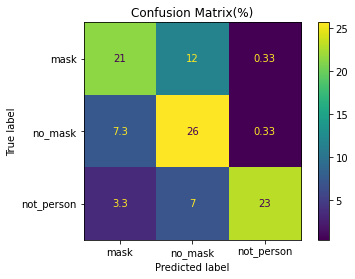

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
torch.manual_seed(6721)
np.random.seed(6721)

cm = confusion_matrix(test_batch, pred_batch, normalize='all')*100
cmd = ConfusionMatrixDisplay(cm, display_labels=['mask', 'no_mask', 'not_person'])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Confusion Matrix(%)')
cmd.plot(ax=ax)


# == End ==